# 타이타닉 생존자 예측하기
### 타이타닉 탑승자 데이터 세트
+ 출처 : <https://www.kaggle.com/c/titanic/data>
+ 데이터 설명
    + Passengerid : 탑승자 데이터 일련번호
    + survived : 생존여부. 0=사망, 1=생존
    + pclass : 티켓의 신설 등급. 1=일등석, 2=이등석, 3=삼등석
    + sex : 탑승자 성별
    + name : 탑승자 이름
    + Age: 탑승자 나이
    + sibsp : 같이 탑승한 형제자매 또는 배우자 인원수
    + parch : 같이 탑승한 부모님 또는 어린이 인원수
    + ticket : 티켓 번호
    + fare : 요금
    + cabin : 선실 번호
    + embarked: 중간 정착 항구. C=Cherbourg, Q=Qweenstown, S=Southampton

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
titanic_df = pd.read_csv('./titanic_train.csv')
titanic_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
print('###  학습 데이터 정보 ### \n')
print(titanic_df.info())

###  학습 데이터 정보 ### 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


---
## 데이터 전처리
### 1. Null 값 처리

In [4]:
titanic_df['Age'].fillna(titanic_df['Age'].mean(), inplace=True)
titanic_df['Cabin'].fillna('N', inplace=True)
titanic_df['Embarked'].fillna('N', inplace=True)
print("데이터 세트의 Null 값 개수 : ", titanic_df.isnull().sum().sum())

데이터 세트의 Null 값 개수 :  0


### 2. 문자열 피처들의 값 처리

In [5]:
print(' Sex 값 분포 : \n', titanic_df['Sex'].value_counts())
print('\n Cabin 값 분포 : \n', titanic_df['Cabin'].value_counts())
print('\n Embarked 값 분포 : \n', titanic_df['Embarked'].value_counts())

 Sex 값 분포 : 
 male      577
female    314
Name: Sex, dtype: int64

 Cabin 값 분포 : 
 N              687
C23 C25 C27      4
G6               4
B96 B98          4
C22 C26          3
              ... 
E34              1
C7               1
C54              1
E36              1
C148             1
Name: Cabin, Length: 148, dtype: int64

 Embarked 값 분포 : 
 S    644
C    168
Q     77
N      2
Name: Embarked, dtype: int64


<span style="font-weight:bold">Cabin</span> 이 N이 687 건으로 지나치게 많고, 속성값이 제대로 정리되어 있지 않음
--> 앞문자만 추출

In [6]:
titanic_df['Cabin'] = titanic_df['Cabin'].str[:1]
print(titanic_df['Cabin'].head(5))

0    N
1    C
2    N
3    C
4    N
Name: Cabin, dtype: object


### <데이터 탐색>

<span style="font-weight:bold">성별에 따른 생존자 수 비교</span> 

In [7]:
titanic_df.groupby(['Sex', 'Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

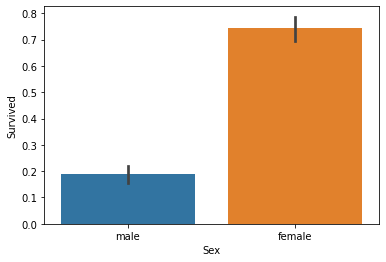

In [8]:
sns.barplot(x='Sex', y='Survived', data=titanic_df)

<span style="font-weight:bold">객실 등급(부)과 성별에 따른 생존자 수 비교</span> 

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

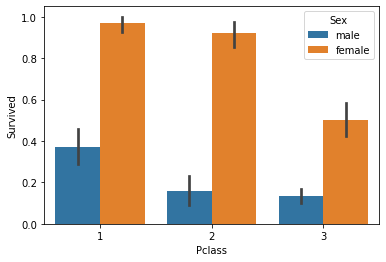

In [9]:
sns.barplot(x="Pclass", y="Survived", hue="Sex", data=titanic_df)

<span style="font-weight:bold">나이에 따른 생존자 수 비교</span> 
+ 0~5세 : Baby
+ 6~12세 : Child
+ 13~18세 : Teenager
+ 19~25세 : Student
+ 26~35세 : Young Adult
+ 36~60세 : Adult
+ 60세~ : Elderly
+ -1이하의 오류값 : Unknown

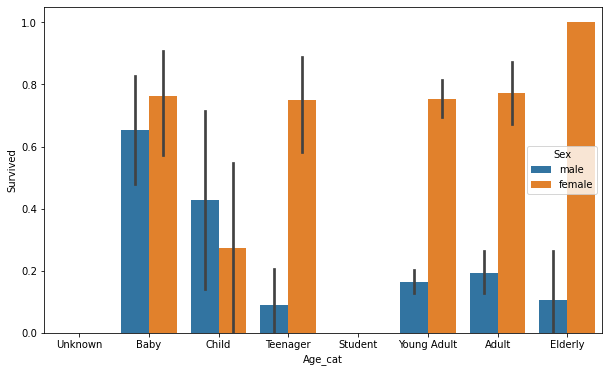

In [10]:
def get_catergory(age):
    cat =''
    if age <=-1: cat='Unknown'
    elif age <= 5 : cat='Baby'
    elif age <= 12 : cat='Child'
    elif age <= 18 : cat='Teenager'
    elif age <= 18 : cat='Student'
    elif age <= 35 : cat='Young Adult'
    elif age <= 60 : cat='Adult'
    else : cat='Elderly'
        
    return cat


# 막대 그래프의 크기 figure를 크게 설정
plt.figure(figsize=(10, 6))

# x축의 값을 순차적으로 표시하기 위한 group_names 생성
group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Elderly']
titanic_df['Age_cat'] = titanic_df['Age'].apply(lambda x : get_catergory(x))
sns.barplot(x="Age_cat", y="Survived", hue="Sex", data=titanic_df, order=group_names)

# Age_cat 다시 삭제
titanic_df.drop('Age_cat', axis=1, inplace=True)

---
### 3. 남아있는 문자열 카테고리 피처 -> 숫자형으로 변환
+ LabelEncoder 로 레이블 인코딩 적용
+ Cabin, Sex, Embarked 를 숫자형으로 변환

In [11]:
from sklearn import preprocessing

def encode_features(dataDF):
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(dataDF[feature])
        dataDF[feature] = le.transform(dataDF[feature])
        
    return dataDF

titanic_df = encode_features(titanic_df)
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,7,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,2,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,7,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,3
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,7,3


---
## 지금까지의 피처 가공 내역을 하나의 함수로 정리
---
+ Null 값 처리 함수
+ 머신러닝 알고리즘에 불필요한 속성 제거
+ 레이블 인코딩 수행(문자열 피처 -> 숫자형 피처)

In [12]:
# Null 값 처리 함수
def fillna(df):
    df['Age'].fillna(titanic_df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    
    return df


# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    
    return df


# 레이블 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
        
    return df


# 앞에서 설정한 데이터 전처리함수 호출하여 전처리 수행
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

---
---
### 원본파일 재로딩(titanic)
+ 원본파일 재로딩 후, 피처 데이터 세트와 레이블 데이터 세트('Survived') 추출

In [13]:
titanic = pd.read_csv('./titanic_train.csv')
y_titanic = titanic['Survived']
X_titanic = titanic.drop('Survived', axis=1)

# 위의 transform_features 함수로 데이터 가공
X_titanic = transform_features (X_titanic)

In [14]:
# 학습 데이터, 테스트 데이터 추출
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_titanic, y_titanic, test_size=0.2, random_state=11)

## ML 알고리즘으로 생존자 예측
+ 결정트리
+ 랜덤 포레스트
+ 로지스틱 회귀

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 결정트리, 랜덤포레스트, 로지스틱 회귀를 위한 Classifier 클래스 생성
dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression()

# DecisionTreeClassifier 학습/예측/평가
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)
print('DecisionTreeClassifier 정확도 : {0:.4f}' .format(accuracy_score(y_test, dt_pred)))

# RandomForestClassifier 학습/예측/평가
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print('RandomForestClassifier 정확도 : {0:.4f}' .format(accuracy_score(y_test, rf_pred)))

# LogisticRegression 학습/예측/평가
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
print('LogisticRegression 정확도 : {0:.4f}' .format(accuracy_score(y_test, lr_pred)))

DecisionTreeClassifier 정확도 : 0.7877
RandomForestClassifier 정확도 : 0.8547
LogisticRegression 정확도 : 0.8492


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 교차검증으로 결정 트리 모델 평가 수행
+ KFold 클래스
+ cross_val_score()
+ GridSearchCV

### KFold

In [16]:
from sklearn.model_selection import KFold

# 폴드 세트 = 5인 KFold 객체 생성
def exec_kfold(clf, folds=5):
    kfold=KFold(n_splits=folds)
    scores=[]
    
    # KFold 교차검증 수행
    for iter_count, (train_index, test_index) in enumerate(kfold.split(X_titanic)):
        #교차검증별로 학습, 검증 데이터 추출
        X_train, X_test = X_titanic.values[train_index], X_titanic.values[test_index]
        y_train, y_test = y_titanic.values[train_index], y_titanic.values[test_index]
        
        #classifier 학습, 예측, 정확도 계산
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        scores.append(accuracy)
        print("교차 검증 {0} 정확도 : {1:.4f}" .format(iter_count, accuracy))
        
    mean_score = np.mean(scores)
    print("평균 정확도 : {0:.4f}" .format(mean_score))
    
# exec_kfold 호출
exec_kfold(dt_clf, folds=5)
    
    

교차 검증 0 정확도 : 0.7542
교차 검증 1 정확도 : 0.7809
교차 검증 2 정확도 : 0.7865
교차 검증 3 정확도 : 0.7697
교차 검증 4 정확도 : 0.8202
평균 정확도 : 0.7823


### cross_val_score()
+ cross_val_score 이 StratifiedKFold 를 이용해 폴드 세트를 분할해서 KFold 평균 정확도가 다름

In [17]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(dt_clf, X_titanic, y_titanic, cv=5)
for iter_count, accuracy in enumerate(scores):
    print("교차 검증 {0} 정확도 {1:.4f}" .format(iter_count, accuracy))
    
print("평균 정확도 : {0:.4f}" .format(np.mean(scores)))

교차 검증 0 정확도 0.7430
교차 검증 1 정확도 0.7753
교차 검증 2 정확도 0.7921
교차 검증 3 정확도 0.7865
교차 검증 4 정확도 0.8427
평균 정확도 : 0.7879


### GridSearchCV
+ GridSearchCv 로 결정 트리의 최적 하이퍼 파라미터를 찾아 예측성능 측정

In [18]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[2,3,5,10], 'min_samples_split':[2,3,5], 'min_samples_leaf':[1,5,8]}

grid_dclf = GridSearchCV(dt_clf, param_grid=parameters, scoring='accuracy', cv=5)
grid_dclf.fit(X_train, y_train)

print('GridSearchCV 최적 하이퍼 파라미터 : ', grid_dclf.best_params_)
print('GridSearchCV 최고 정확도 : {0:.4f}' .format(grid_dclf.best_score_))

# GridSearchCV의 의 refit으로 학습된 estimator 반환
best_dclf = grid_dclf.best_estimator_

#GridSearchCV의 최적 하이퍼 파라미터로 학습된 Estimator로 예측 및 평가 수행
dpredictions = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test, dpredictions)
print("테스트 세트에서의 DecisionTreeClassifier 정확도 : {0:.4f}" .format(accuracy))

GridSearchCV 최적 하이퍼 파라미터 :  {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
GridSearchCV 최고 정확도 : 0.7992
테스트 세트에서의 DecisionTreeClassifier 정확도 : 0.8715


<span style="font-weight:bold">예측 정확도가 0.8715 로 향상</span>  
일반적으로 약 8% 이상 증가하기 어려운데, 테스트용 데이터 세트가 작기 때문에 예측성능이 많이 증가된 것으로 예상됨